In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [2]:
!wget 'https://raw.githubusercontent.com/pocahontasabi/Ml_b/master/DrawIt/classes.txt'

--2019-05-02 11:11:57--  https://raw.githubusercontent.com/pocahontasabi/Ml_b/master/DrawIt/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 759 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]     759  --.-KB/s    in 0s      

2019-05-02 11:11:57 (66.8 MB/s) - ‘classes.txt’ saved [759/759]



In [0]:
f = open("classes.txt","r")   #file with 100 classes from quick draw
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [0]:
!mkdir data #download data from googleapi

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [8]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [10]:
len(x_train)

320000

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flat

In [13]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 288000 samples, validate on 32000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 26s - loss: 1.9194 - top_k_categorical_accuracy: 0.7811 - val_loss: 1.3377 - val_top_k_categorical_accuracy: 0.8828
Epoch 2/5
 - 13s - loss: 1.2388 - top_k_categorical_accuracy: 0.8939 - val_loss: 1.1671 - val_top_k_categorical_accuracy: 0.9014
Epoch 3/5
 - 8s - loss: 1.0864 - top_k_categorical_accuracy: 0.9102 - val_loss: 1.0720 - val_top_k_categorical_accuracy: 0.9110
Epoch 4/5
 - 14s - loss: 0.9989 - top_k_categorical_accuracy: 0.9191 - val_loss: 0.9847 - val_top_k_categorical_accuracy: 0.9197
Epoch 5/5
 - 23s - loss: 0.9406 - top_k_categorical_accuracy: 0.9252 - val_loss: 0.9615 - val_top_k_categorical_accuracy: 0.9218


In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))


Test accuarcy: 92.06%


anvil


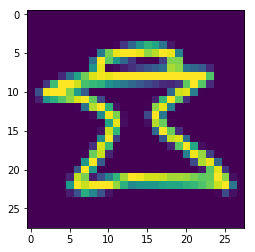

In [23]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[0]
latex = class_names[ind]
print(latex)

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [26]:
model.save('model.h5')

In [27]:
pip install coremltools

In [0]:
from keras.models import load_model
import keras
import coremltools

In [38]:


import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model('model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [39]:
coreml_model = coremltools.converters.keras.convert(model)
coreml_model.save('my_model.mlmodel')

0 : conv2d_input, <keras.engine.input_layer.InputLayer object at 0x7f79f52d8a58>
1 : conv2d, <keras.layers.convolutional.Conv2D object at 0x7f79f52d8898>
2 : conv2d__activation__, <keras.layers.core.Activation object at 0x7f79f519b128>
3 : max_pooling2d, <keras.layers.pooling.MaxPooling2D object at 0x7f79f52d8ac8>
4 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7f79f5244a90>
5 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x7f79f5186128>
6 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7f79f5342c18>
7 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7f79f52d8e48>
8 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x7f79f52fe668>
9 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x7f79f5206630>
10 : flatten, <keras.layers.core.Flatten object at 0x7f79f53429b0>
11 : dense, <keras.layers.core.Dense object at 0x7f79f51af198>
12 : dense__activation__, <keras.layers.core.Activation object at 0x7f79

In [0]:
!mkdir model

In [41]:
!zip -r model.zip model 

  adding: model/ (stored 0%)


In [0]:
from google.colab import files
files.download('model.zip')